# Dataset Processor #

This notebook contains steps for dataset analisys and preparation to be used in training of a neural network.

In [1]:
import tensorflow as tf
print(tf.__version__)

1.3.0


Be aware of version compatibility. This copybook uses functions form Trensorflow package version 1.3.0 and higher.

### Imports ###

In [2]:
# Some important imports
import math
import numpy as np
import colorsys
import matplotlib.pyplot as plt
%matplotlib inline
import random
import pickle

### Load data ###

In [3]:
# If your files are named differently or placed in a different folder, please update lines below.
training_file ="./raw_data/train.p" 
validation_file = "./raw_data/valid.p"
testing_file = "./raw_data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

# Make sure that the number of features equals the number of labels
assert(len(X_train) == len(y_train))
assert(len(X_valid) == len(y_valid))
assert(len(X_test) == len(y_test))

### Basic Summary ###

In [4]:
# Number of training examples
n_train = X_train.shape[0]
# Number of training labels
n_train_lables = y_train.shape[0]

# Number of validation examples
n_validation = X_valid.shape[0]
# Number of validation labels
n_validation_labels = y_valid.shape[0]

# Number of testing examples
n_test = X_test.shape[0]
# Number of test labels
n_test_labels = y_test.shape[0]

# The shape of an traffic sign image
train_image_shape = [X_train.shape[1], X_train.shape[2], X_train.shape[3]]
valid_image_shape = [X_valid.shape[1], X_valid.shape[2], X_valid.shape[3]]
test_image_shape  = [X_test.shape[1], X_test.shape[2], X_test.shape[3]]

# Number of unique classes/labels in the dataset.
n_classes = len(set(train['labels']))

print("Number of training examples =", n_train)
print("Number of training  labels  =", n_train_lables)
print()
print("Number of validation examples =", n_validation)
print("Number of validation  labels  =", n_validation)
print()
print("Number of testing examples =", n_test)
print("Number of testing  labels  =", n_test)
print()
print("Training image data shape   =", train_image_shape)
print("Validation image data shape =", valid_image_shape)
print("Test  image  data  shape    =", test_image_shape)
print()
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of training  labels  = 34799

Number of validation examples = 4410
Number of validation  labels  = 4410

Number of testing examples = 12630
Number of testing  labels  = 12630

Training image data shape   = [32, 32, 3]
Validation image data shape = [32, 32, 3]
Test  image  data  shape    = [32, 32, 3]

Number of classes = 43


### Some exploratory visualizations ###

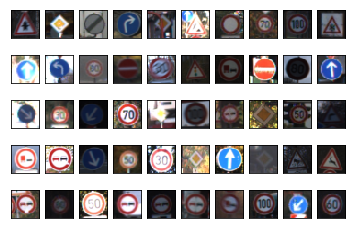

In [5]:
n_pics_row = 5
n_pic_col = 10

plots = []
for i in range(n_pics_row):
    for j in range(n_pic_col):
        ax = plt.subplot2grid((n_pics_row,n_pic_col), (i,j))
        ax.imshow(X_train[random.randint(0, n_train)][:][:][:], cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
plt.show()

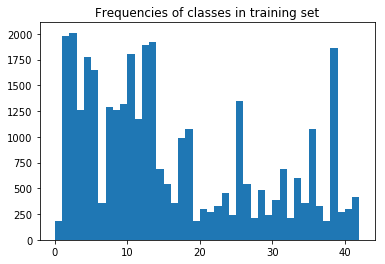

In [6]:
# Frequencies of training data per class
plt.hist(y_train, bins = np.arange(n_classes))  # arguments are passed to np.histogram
plt.title("Frequencies of classes in training set")
plt.show()

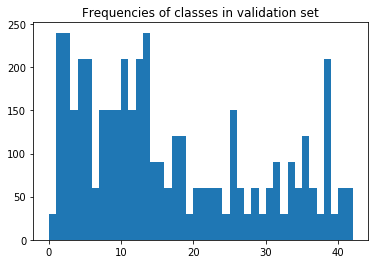

In [7]:
# Frequencies of validation data per class
plt.hist(y_valid, bins = np.arange(n_classes))  # arguments are passed to np.histogram
plt.title("Frequencies of classes in validation set")
plt.show()

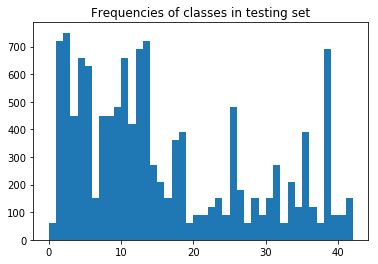

In [8]:
# Frequencies of test data per class
plt.hist(y_test, bins = np.arange(n_classes))  # arguments are passed to np.histogram
plt.title("Frequencies of classes in testing set")
plt.show()

Note: in terms of frequencies, it can be confirmed that the dataset was divided correctly. Training, validation and testing data have similar histograms of class frequencies. 

### Normalize all data ###

In [9]:
def normalize_img(image_data):
    """
    Normalize the image data with Min-Max scaling to a range of [0.1, 0.9],
        :param image_data: The image data to be normalized,
        :return: Normalized image data.
    """
    a = 0.1
    b = 0.9
    scale_min = 0
    scale_max = 255
    return a + (((image_data - scale_min)*(b - a))/(scale_max - scale_min))

X_train_norm = normalize_img(X_train)
X_valid_norm = normalize_img(X_valid)
X_test_norm  = normalize_img(X_test)

### Transform normalized RGB image to grayscale ###

In [10]:
tf.reset_default_graph()
X_train2gray  = tf.image.rgb_to_grayscale(X_train_norm)

with tf.Session() as sess:
    X_train_gray = sess.run(X_train2gray)

### Create rotated images from normalized original data ###

At this point, the training data will be extended with rotated images (-15, +15 deg).

In [11]:
tf.reset_default_graph()
X_train_rotated_ccw = tf.contrib.image.rotate(X_train_norm, 15 * math.pi / 180, interpolation='BILINEAR')
X_train_rotated_cw  = tf.contrib.image.rotate(X_train_norm, -15 * math.pi / 180, interpolation='BILINEAR')

with tf.Session() as sess:
    rotated_images_ccw = sess.run(X_train_rotated_ccw)
    rotated_images_cw  = sess.run(X_train_rotated_cw)    

In [12]:
tf.reset_default_graph()
rotated_ccw2gray  = tf.image.rgb_to_grayscale(rotated_images_ccw) # Ready to export
rotated_cw2gray   = tf.image.rgb_to_grayscale(rotated_images_cw)  # Ready to export

with tf.Session() as sess:
    rotated_images_ccw_gray = sess.run(rotated_ccw2gray)
    rotated_images_cw_gray  = sess.run(rotated_cw2gray)

# Copy labels for rotated images
rotated_ccw_labels = y_train
rotated_cw_labels  = y_train

### Modify brightness randomly ###

Make a copy of training data and modify randomly a brightness of each image. 

In [13]:
# Time consuming task! Function is sequential. TODO: optimize it.
def random_brightness(image):
    """
    Modify image bightness with following formula: brightness = 0.2 + np.random.uniform(),
        :param image: The image data to be processed,
        :return: Modified image data
    """
    result = image
    for i in range(image.shape[0]):
        one_image = image[i][:][:][:]
        brightness = 0.2 + np.random.uniform()
        for x in range(one_image.shape[0]):
            for y in range(one_image.shape[1]):
                h, s, v = colorsys.rgb_to_hsv(one_image[x][y][0], one_image[x][y][1], one_image[x][y][2])
                v = v * brightness
                one_image[x][y][0], one_image[x][y][1], one_image[x][y][2] = colorsys.hsv_to_rgb(h, s, v)
        result[i][:][:][:] = one_image[:][:][:]
    return result

## Create a copy of original dataset and modify imeges' brightness
X_train_bright = random_brightness(X_train_norm)
y_train_bright = y_train

Convert processed images to grayscale.

In [14]:
tf.reset_default_graph()
X_train_bright2gray   = tf.image.rgb_to_grayscale(X_train_bright)

with tf.Session() as sess:
    X_train_bright_gray = sess.run(X_train_bright2gray)

### Add random noise ###

In [15]:
# Time consuming task! Function is sequential. TODO: optimize it.
def random_noise(image):
    result = image
    for i in range(image.shape[0]):
        one_image = image[i][:][:][:]
        for x in range(one_image.shape[0]):
            for y in range(one_image.shape[1]):
                brightness = np.random.uniform(low=0.0, high=0.3) # be careful with upper limit -> impact validation 
                h, s, v = colorsys.rgb_to_hsv(one_image[x][y][0], one_image[x][y][1], one_image[x][y][2])
                v = v * brightness
                one_image[x][y][0], one_image[x][y][1], one_image[x][y][2] = colorsys.hsv_to_rgb(h, s, v)
        result[i][:][:][:] = one_image[:][:][:]
    return result

X_train_noise = random_noise(X_train_norm)
y_train_noise = y_train

In [16]:
tf.reset_default_graph()
X_train_noise2gray   = tf.image.rgb_to_grayscale(X_train_noise)

with tf.Session() as sess:
    X_train_noise_gray = sess.run(X_train_noise2gray)

### Concatenate all training data together ###

In [17]:
X_train_ready = X_train_gray
y_train_ready = y_train

X_train_ready = np.append(X_train_ready, rotated_images_ccw_gray, axis=0)
y_train_ready = np.append(y_train_ready, rotated_ccw_labels, axis=0)

X_train_ready = np.append(X_train_ready, rotated_images_cw_gray, axis=0)
y_train_ready = np.append(y_train_ready, rotated_cw_labels, axis=0)

X_train_ready = np.append(X_train_ready, X_train_bright_gray, axis=0)
y_train_ready = np.append(y_train_ready, y_train_bright, axis=0)

X_train_ready = np.append(X_train_ready, X_train_noise_gray, axis=0)
y_train_ready = np.append(y_train_ready, y_train_noise, axis=0)

### Convert to grayscale validation and test data ###

In [18]:
tf.reset_default_graph()
X_valid_gray  = tf.image.rgb_to_grayscale(X_valid_norm) # Ready to export
X_test_gray   = tf.image.rgb_to_grayscale(X_test_norm)  # Ready to export

with tf.Session() as sess:
    X_valid_ready = sess.run(X_valid_gray)
    X_test_ready  = sess.run(X_test_gray)

# Propagate their labels
y_valid_ready = y_valid 
y_test_ready  = y_test

In [19]:
print("Training dataset shape: ", X_train_ready.shape)
print("Validation dataset shape: ", X_valid_ready.shape)
print("Test dataset shape: ", X_test_ready.shape)

Training dataset shape:  (173995, 32, 32, 1)
Validation dataset shape:  (4410, 32, 32, 1)
Test dataset shape:  (12630, 32, 32, 1)


In [20]:
# Make sure that the number of features equals the number of labels
assert(len(X_train_ready) == len(y_train_ready))
assert(len(X_valid_ready) == len(y_valid_ready))
assert(len(X_test_ready)  == len(y_test_ready))

In [22]:
with open('./train_data/aug_train_features_ready2.pickle', 'wb') as output:
    pickle.dump(X_train_ready, output)

with open('./train_data/aug_train_labels_ready2.pickle', 'wb') as output:
    pickle.dump(y_train_ready, output)
    
with open('./train_data/aug_valid_features_ready2.pickle', 'wb') as output:
    pickle.dump(X_valid_ready, output)

with open('./train_data/aug_valid_labels_ready2.pickle', 'wb') as output:
    pickle.dump(y_valid_ready, output)
    
with open('./train_data/aug_test_features_ready2.pickle', 'wb') as output:
    pickle.dump(X_test_ready, output)

with open('./train_data/aug_test_labels_ready2.pickle', 'wb') as output:
    pickle.dump(y_test_ready, output)

Observation: tensor graph needs to be reset all the time in order to avoid 2 GB limit overflow; at the beginning, functions were ment to work with RGB images. Repeat RGB to grayscale conversion is not so elegant and time consuming. This notebook may be optimized and gain significant performance in future.